In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from imblearn.under_sampling import ClusterCentroids
from sklearn_pandas import DataFrameMapper

# Data Preprocessing
The first step is to read in the data to a Pandas DataFrame.

In [2]:
users = pd.read_csv('data/users.csv', encoding='latin1')
engagement = pd.read_csv('data/user-engagement.csv')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


I converted the object_id column to the users index to join it with the engagement table later.

In [4]:
users.index = users.object_id
users = users.drop('object_id',1)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


I then converted the time_stamp column to the engagement index to enable rolling window operations.

In [6]:
engagement.index = pd.to_datetime(engagement.time_stamp)
engagement = engagement.drop('time_stamp',1)
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


Next I grouped all logins by user_id and performed a rolling 7-day count of the visited column. 

In [7]:
weekly_logins = engagement.groupby('user_id')['visited'].rolling('7D').count()
weekly_logins.head()

user_id  time_stamp         
1        2014-04-22 03:53:30    1.0
2        2013-11-15 03:45:04    1.0
         2013-11-29 03:45:04    1.0
         2013-12-09 03:45:04    1.0
         2013-12-25 03:45:04    1.0
Name: visited, dtype: float64

This enabled me to easily find users who logged into to product on three separate days in a seven-day period and mark those users as adopted. I then added the adopted column to the users table.

In [8]:
adopted = weekly_logins.groupby('user_id').max() > 2
users = users.join(adopted)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


Next I accounted for users that have never logged into the product by setting the visited column to False for those users. I also accounted for those that were not invited by another user by setting invited_by_user_id to 0, which is not an actual user ID and becomes a proxy to represent not invited by another user.

In [9]:
users.loc[users.visited.isnull(), 'visited'] = False
users.loc[users.invited_by_user_id.isnull(), 'invited_by_user_id'] = 0

# Predicting Future Adoption
Few users actually adopted the product per the definition in the problem description. This results in a biased dataset, so I experimented with resampling to see if that improves predictive capability of the model.

In [10]:
visited = users.visited
print('{:.2f}% of all users were adopted'.format(100 * sum(visited) / len(users)))
print(visited.value_counts())

13.35% of all users were adopted
False    10398
True      1602
Name: visited, dtype: int64


I first created a DataFrameMapper from the sklearn_pandas module. This module provides a class to transform Pandas DataFrames to a desired format suitable for scikit-learn classifiers. It is intended to be used inside a scikit-learn Pipeline, but here I just use it to transform the DataFrame. Each desired column is mapped to a transformer to be applied on that column. Here I used a LabelEncoder to transform the creation_source and org_id columns. A transformer of None indicates the DataFrameMapper passes data from that column as is. Columns not included in the DataFrameMapper are discarded. I used these four variables because they provided the best results after experimenting with various variable combinations.

In [11]:
mapper = DataFrameMapper([
    ('creation_source', LabelEncoder()),
    ('org_id', LabelEncoder()),
    ('opted_in_to_mailing_list', None),
    ('enabled_for_marketing_drip', None)
])

Next I fit the mapper and used it to transform the entire dataset. I also encoded user adoption from False and True to 0 and 1.

In [12]:
x = mapper.fit_transform(users)
y = LabelEncoder().fit_transform(visited)

I then split the mapped data into training and test sets.

In [13]:
random_state = 8
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

The train_test_split function uses stratified sampling by default. I printed the adoption counts to verify that the adoption percentage of the entire dataset is maintained in the training and test sets.

In [14]:
print('Original data adoption split')
print(np.bincount(y))
print('\nTraining set adoption split')
print(np.bincount(y_train))
print('\nTest set adoption split')
print(np.bincount(y_test))

Original data adoption split
[10398  1602]

Training set adoption split
[8319 1281]

Test set adoption split
[2079  321]


The function defined below displays a nicely formatted confusion matrix. It is a slightly modified version of the function found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [15]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

I then fit a random forest model on the training data and printed accuracy, precision, and recall on the test set. I included precision and recall because accuracy is not always the best metric in a classification task, particularly for biased datasets. A model that always predicts a user will not adopt the product will be right most of the time, but is not very useful. We are also probably more interested in predicting users that will adopt the product in this dataset. The metrics below show that accuracy is high, but precision and recall are low. This indicates the model is primarly predicting the majority class.

In [16]:
model = RandomForestClassifier(random_state=random_state)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.8271
Precision: 0.2235
Recall: 0.1184


The confusion matrix confirms this hypothesis. The vast majority of predictions are false, which leads to an accurate model that is useless in practice.

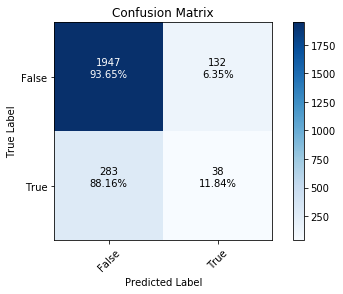

In [17]:
plot_confusion_matrix(confusion_matrix(y_test, pred), ['False', 'True'])

Since the data is biased, I undersampled the data using the ClusterCentroids class from the imbalanced-learn module. This allows me to undersample instances of the majority class to make the dataset balanced. I then split the sampled data into new training and test sets.

In [18]:
cc = ClusterCentroids(random_state=random_state)
x_res, y_res = cc.fit_sample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=random_state)

I printed the counts of each class to verify the resampled and split data are balanced.

In [19]:
print('Resampled data adoption split')
print(np.bincount(y_res))
print('\nTraining set adoption split')
print(np.bincount(y_train))
print('\nTest set adoption split')
print(np.bincount(y_test))

Resampled data adoption split
[1602 1602]

Training set adoption split
[1294 1269]

Test set adoption split
[308 333]


Lastly, I retrained the model on the new training data from the resampled data and print the same metrics as above on the new test set. Accuracy decreased slightly, but precision and recall increased substantially.

In [20]:
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.7535
Precision: 0.7660
Recall: 0.7568


The confusion matrix shows that the majority of instances are along the diagonal as they ideally are.

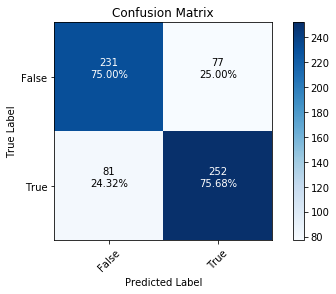

In [21]:
plot_confusion_matrix(confusion_matrix(y_test, pred), ['False', 'True'])